<a href="https://colab.research.google.com/github/AxelGautrand/Digitalization-in-Sports/blob/main/statsbomb_runonce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from IPython.display import clear_output

In [ ]:
# Uncomment these lines (only once)
#%cd drive/My\ Drive/DIS/Clone
#!git clone https://github.com/statsbomb/open-data.git

In [3]:
!pip install statsbombpy
clear_output()

In [4]:
!pip install mplsoccer
clear_output()

In [5]:
dataset = "/content/drive/My Drive/DIS/Colab/open-data/data/"

In [6]:
from statsbombpy import sb
import pandas as pd
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib.patches import Ellipse
from matplotlib.colorbar import constrained_layout
import matplotlib.patheffects as path_effects
from mplsoccer.pitch import Pitch
from shapely.geometry import Polygon as shapelyPolygon
from scipy.stats import norm
from collections import Counter, defaultdict

In [7]:
from google.colab import data_table
data_table.enable_dataframe_formatter()  # For tables with lines

In [ ]:
def createPitch(length,width, unity,linecolor): # in meters
    # Code by @JPJ_dejong

    """
    creates a plot in which the 'length' is the length of the pitch (goal to goal).
    And 'width' is the width of the pitch (sideline to sideline). 
    Fill in the unity in meters or in yards.
    """
    #Set unity
    if unity == "meters":
        # Set boundaries
        if length >= 120.5 or width >= 75.5:
            return(str("Field dimensions are too big for meters as unity, didn't you mean yards as unity?\
                       Otherwise the maximum length is 120 meters and the maximum width is 75 meters. Please try again"))
        #Run program if unity and boundaries are accepted
        else:
            #Create figure
            fig=plt.figure()
            #fig.set_size_inches(7, 5)
            ax=fig.add_subplot(1,1,1)
           
            #Pitch Outline & Centre Line
            plt.plot([0,0],[0,width], color=linecolor)
            plt.plot([0,length],[width,width], color=linecolor)
            plt.plot([length,length],[width,0], color=linecolor)
            plt.plot([length,0],[0,0], color=linecolor)
            plt.plot([length/2,length/2],[0,width], color=linecolor)
            
            #Left Penalty Area
            plt.plot([16.5 ,16.5],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
            plt.plot([0,16.5],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
            plt.plot([16.5,0],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)
            
            #Right Penalty Area
            plt.plot([(length-16.5),length],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
            plt.plot([(length-16.5), (length-16.5)],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
            plt.plot([(length-16.5),length],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)
            
            #Left 5-meters Box
            plt.plot([0,5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
            plt.plot([5.5,5.5],[(width/2+7.32/2+5.5),(width/2-7.32/2-5.5)],color=linecolor)
            plt.plot([5.5,0.5],[(width/2-7.32/2-5.5),(width/2-7.32/2-5.5)],color=linecolor)
            
            #Right 5 -eters Box
            plt.plot([length,length-5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
            plt.plot([length-5.5,length-5.5],[(width/2+7.32/2+5.5),width/2-7.32/2-5.5],color=linecolor)
            plt.plot([length-5.5,length],[width/2-7.32/2-5.5,width/2-7.32/2-5.5],color=linecolor)
            
            #Prepare Circles
            centreCircle = plt.Circle((length/2,width/2),9.15,color=linecolor,fill=False)
            centreSpot = plt.Circle((length/2,width/2),0.8,color=linecolor)
            leftPenSpot = plt.Circle((11,width/2),0.8,color=linecolor)
            rightPenSpot = plt.Circle((length-11,width/2),0.8,color=linecolor)
            
            #Draw Circles
            ax.add_patch(centreCircle)
            ax.add_patch(centreSpot)
            ax.add_patch(leftPenSpot)
            ax.add_patch(rightPenSpot)
            
            #Prepare Arcs
            leftArc = Arc((11,width/2),height=18.3,width=18.3,angle=0,theta1=308,theta2=52,color=linecolor)
            rightArc = Arc((length-11,width/2),height=18.3,width=18.3,angle=0,theta1=128,theta2=232,color=linecolor)
            
            #Draw Arcs
            ax.add_patch(leftArc)
            ax.add_patch(rightArc)
            #Axis titles

    #check unity again
    elif unity == "yards":
        #check boundaries again
        if length <= 95:
            return(str("Didn't you mean meters as unity?"))
        elif length >= 131 or width >= 101:
            return(str("Field dimensions are too big. Maximum length is 130, maximum width is 100"))
        #Run program if unity and boundaries are accepted
        else:
            #Create figure
            fig=plt.figure()
            #fig.set_size_inches(7, 5)
            ax=fig.add_subplot(1,1,1)
           
            #Pitch Outline & Centre Line
            plt.plot([0,0],[0,width], color=linecolor)
            plt.plot([0,length],[width,width], color=linecolor)
            plt.plot([length,length],[width,0], color=linecolor)
            plt.plot([length,0],[0,0], color=linecolor)
            plt.plot([length/2,length/2],[0,width], color=linecolor)
            
            #Left Penalty Area
            plt.plot([18 ,18],[(width/2 +18),(width/2-18)],color=linecolor)
            plt.plot([0,18],[(width/2 +18),(width/2 +18)],color=linecolor)
            plt.plot([18,0],[(width/2 -18),(width/2 -18)],color=linecolor)
            
            #Right Penalty Area
            plt.plot([(length-18),length],[(width/2 +18),(width/2 +18)],color=linecolor)
            plt.plot([(length-18), (length-18)],[(width/2 +18),(width/2-18)],color=linecolor)
            plt.plot([(length-18),length],[(width/2 -18),(width/2 -18)],color=linecolor)
            
            #Left 6-yard Box
            plt.plot([0,6],[(width/2+7.32/2+6),(width/2+7.32/2+6)],color=linecolor)
            plt.plot([6,6],[(width/2+7.32/2+6),(width/2-7.32/2-6)],color=linecolor)
            plt.plot([6,0],[(width/2-7.32/2-6),(width/2-7.32/2-6)],color=linecolor)
            
            #Right 6-yard Box
            plt.plot([length,length-6],[(width/2+7.32/2+6),(width/2+7.32/2+6)],color=linecolor)
            plt.plot([length-6,length-6],[(width/2+7.32/2+6),width/2-7.32/2-6],color=linecolor)
            plt.plot([length-6,length],[(width/2-7.32/2-6),width/2-7.32/2-6],color=linecolor)
            
            #Prepare Circles; 10 yards distance. penalty on 12 yards
            centreCircle = plt.Circle((length/2,width/2),10,color=linecolor,fill=False)
            centreSpot = plt.Circle((length/2,width/2),0.8,color=linecolor)
            leftPenSpot = plt.Circle((12,width/2),0.8,color=linecolor)
            rightPenSpot = plt.Circle((length-12,width/2),0.8,color=linecolor)
            
            #Draw Circles
            ax.add_patch(centreCircle)
            ax.add_patch(centreSpot)
            ax.add_patch(leftPenSpot)
            ax.add_patch(rightPenSpot)
            
            #Prepare Arcs
            leftArc = Arc((11,width/2),height=20,width=20,angle=0,theta1=312,theta2=48,color=linecolor)
            rightArc = Arc((length-11,width/2),height=20,width=20,angle=0,theta1=130,theta2=230,color=linecolor)
            
            #Draw Arcs
            ax.add_patch(leftArc)
            ax.add_patch(rightArc)
                
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax


In [ ]:
!pwd
writePath = "drive/My Drive/DIS/Write"
%cd $writePath
clear_output()

In [ ]:
class CreateEvent360():
    def __init__(self):
        self.competitionId = 53
        self.seasonId = 106
        self.fmt = "dict"
        self.matchInfo = self.get_all_matches_info()
        self.matchId = list(self.matchInfo.keys())
        self.matchEvents = dict(zip(self.matchId, list(map(self.get_all_events_from_match, self.matchId))))
        self.matchFrames = dict(zip(self.matchId, list(map(self.get_all_360_frames_from_match, self.matchId))))
        self.matchEventLocations = dict(zip(self.matchId, list(map(self.get_event_id_matching_360_events, self.matchId))))

        for iMatchId in self.matchId:
            self.fill_event_frame_location_details(iMatchId)
            self.exportJson(iMatchId)


    def get_all_matches_info(self):
        return sb.matches(competition_id=self.competitionId, season_id=self.seasonId, fmt=self.fmt)

    def get_all_events_from_match(self, matchId):
        return sb.events(matchId, fmt=self.fmt)

    def get_all_360_frames_from_match(self, matchId):
        return sb.frames(matchId, fmt=self.fmt)

    def get_event_id_matching_360_events(self, matchId):
        eventsIds = [self.matchFrames[matchId][iEventIndex]['event_uuid'] for iEventIndex in
                     range(len(self.matchFrames[matchId]))]
        #return dict(zip(eventsIds, len(eventsIds) * [{'possession': None, 'eventLoc': None, 'homeLoc': list(), 'awayLoc': list()}]))
        return {x: {'possession': None, 'eventLoc': None, 'homeLoc': list(), 'awayLoc': list()} for x in eventsIds}

    def fill_event_frame_location_details(self, matchId):
        for iEventIndex in range(len(self.matchFrames[matchId])):
            iEvent = self.matchFrames[matchId][iEventIndex]['event_uuid']
            if 'location' in self.matchEvents[matchId][iEvent].keys():
                self.matchEventLocations[matchId][iEvent]['eventLoc'] = self.matchEvents[matchId][iEvent]['location']
            if 'period' in self.matchEvents[matchId][iEvent].keys():
                self.matchEventLocations[matchId][iEvent]['period'] = self.matchEvents[matchId][iEvent]['period']
            possessionId = self.matchEvents[matchId][iEvent]['possession_team']['id']
            if possessionId == self.matchInfo[matchId]['home_team']['home_team_id']:
                possession = 'home'
            else:
                possession = 'away'
            self.matchEventLocations[matchId][iEvent]['possession'] = possession
            for iPlayer in self.matchFrames[matchId][iEventIndex]['freeze_frame']:
                if possession == 'home':
                    if iPlayer['teammate']:
                        self.matchEventLocations[matchId][iEvent]['homeLoc'].append(iPlayer['location'])
                    else:
                        self.matchEventLocations[matchId][iEvent]['awayLoc'].append(iPlayer['location'])
                elif possession == 'away':
                    if iPlayer['teammate']:
                        self.matchEventLocations[matchId][iEvent]['awayLoc'].append(iPlayer['location'])
                    else:
                        self.matchEventLocations[matchId][iEvent]['awayLoc'].append(iPlayer['location'])
                        
    def exportJson(self, matchId):
          fileName = str(matchId) + '.json'
          with open(fileName, 'w') as fh:
              json.dump(self.matchEventLocations[matchId], fh)
          fh.close()

In [ ]:
# Only once
event360 = CreateEvent360()
clear_output()

In [ ]:
def loadJson(matchId):
    filename = str(matchId) + '.json'
    with open(filename, 'r') as fh:
        matchData = json.load(fh)
    fh.close()
    return matchData

In [ ]:
matchdata = loadJson(3847567)

In [ ]:
# method 1 - Home at left and away at right always
def drawLocations(matchdata, voronoi=False, samples=-1, eventColor='black', homeColor='red', awayColor='blue'):
    for sampleNumber, iEvent in enumerate(matchdata.keys()):
        if sampleNumber >= samples:
          break
        voronoiHomeXY = list()
        voronoiAwayXY = list()
        (fig,ax) = createPitch(120,80,'yards','gray')
        if len(matchdata[iEvent]['eventLoc']) > 0:
            x = matchdata[iEvent]['eventLoc'][0]
            y = matchdata[iEvent]['eventLoc'][1]
            x = xComplimentPostHalf(x, matchdata[iEvent]['period'])
            positionBall = plt.Circle((x,y),2,color=eventColor)
            ax.add_patch(positionBall)

            for i in range(len(matchdata[iEvent]['homeLoc'])):
                x=matchdata[iEvent]['homeLoc'][i][0]
                y=matchdata[iEvent]['homeLoc'][i][1]
                x = xComplimentPostHalf(x, matchdata[iEvent]['period'])
                position = plt.Circle((x,y),2,color=homeColor)
                ax.add_patch(position)
                voronoiHomeXY.append((x, y, 0))

            for j in range(len(matchdata[iEvent]['awayLoc'])):
                x=matchdata[iEvent]['awayLoc'][j][0]
                y=matchdata[iEvent]['awayLoc'][j][1]
                x = xComplimentPostHalf(x, matchdata[iEvent]['period'])
                position = plt.Circle((x,y),2,color=awayColor)
                ax.add_patch(position)
                voronoiAwayXY.append((x, y, 1))

        if voronoi == True:
            voronoiDF = pd.DataFrame({'x' : [i[0] for i in voronoiHomeXY] + [i[0] for i in voronoiAwayXY], 
                                      'y' : [i[1] for i in voronoiHomeXY] + [i[1] for i in voronoiAwayXY],
                                      'team' : [i[2] for i in voronoiHomeXY] + [i[2] for i in voronoiAwayXY]})

            pitch = Pitch(pitch_type = 'statsbomb')
            team1, team2 = pitch.voronoi(voronoiDF.x, voronoiDF.y, voronoiDF.team)

            t1 = pitch.polygon(team1, ax=ax, fc='lightskyblue', ec='white', lw=3, alpha=.1)
            t2 = pitch.polygon(team2, ax=ax, fc='lightsalmon', ec='white', lw=3, alpha=.1)

            # Event location plotting again to make it visible
            x = matchdata[iEvent]['eventLoc'][0]
            y = matchdata[iEvent]['eventLoc'][1]
            x = xComplimentPostHalf(x, matchdata[iEvent]['period'])
            positionBall = plt.Circle((x,y),2,color=eventColor)
            ax.add_patch(positionBall)

        fig.set_size_inches(10, 7)
        plt.show()

def xComplimentPostHalf(x, period):
    if period == 2:
        x = 120-x
    return x

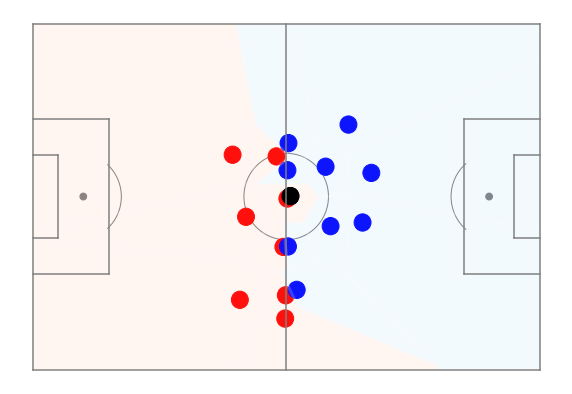

In [ ]:
drawLocations(matchdata, samples=1, voronoi=True)

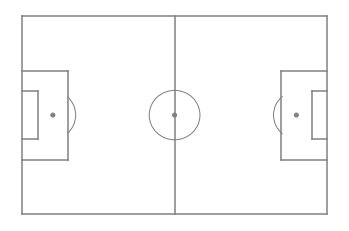

In [ ]:
(fig,ax) = createPitch(120,80,'yards','gray')
def getAreasForEachEvent(matchdata, voronoi=True, numPlayersContrast=3, samples=-1, lastPlayerAsBoundary=True):
    areaT1 = list()
    areaT2 = list()
    for sampleNumber, iEvent in enumerate(matchdata.keys()):
        if samples >= sampleNumber:
          break
        voronoiHomeXY = list()
        voronoiAwayXY = list()
        if matchdata[iEvent]['eventLoc'] is not None and len(matchdata[iEvent]['eventLoc']) > 0 and abs(len(matchdata[iEvent]['homeLoc']) - len(matchdata[iEvent]['awayLoc'])) <= numPlayersContrast:
            minX = 120
            maxX = 0
            x = matchdata[iEvent]['eventLoc'][0]
            y = matchdata[iEvent]['eventLoc'][1]
            x = xComplimentPostHalf(x, matchdata[iEvent]['period'])
            minX, maxX = setMinXMaxX(minX, maxX, x, lastPlayerAsBoundary)

            for i in range(len(matchdata[iEvent]['homeLoc'])):
                x=matchdata[iEvent]['homeLoc'][i][0]
                y=matchdata[iEvent]['homeLoc'][i][1]
                x = xComplimentPostHalf(x, matchdata[iEvent]['period'])
                voronoiHomeXY.append((x, y, 0))
                minX, maxX = setMinXMaxX(minX, maxX, x, lastPlayerAsBoundary)

            for j in range(len(matchdata[iEvent]['awayLoc'])):
                x=matchdata[iEvent]['awayLoc'][j][0]
                y=matchdata[iEvent]['awayLoc'][j][1]
                x = xComplimentPostHalf(x, matchdata[iEvent]['period'])
                voronoiAwayXY.append((x, y, 1))
                minX, maxX = setMinXMaxX(minX, maxX, x, lastPlayerAsBoundary)

            if voronoi == True:
                voronoiDF = pd.DataFrame({'x' : [i[0] for i in voronoiHomeXY] + [i[0] for i in voronoiAwayXY], 
                                          'y' : [i[1] for i in voronoiHomeXY] + [i[1] for i in voronoiAwayXY],
                                          'team' : [i[2] for i in voronoiHomeXY] + [i[2] for i in voronoiAwayXY]})

                pitch = Pitch(pitch_type = 'statsbomb')
                team1, team2 = pitch.voronoi(voronoiDF.x, voronoiDF.y, voronoiDF.team)

                t1 = pitch.polygon(team1, ax=ax, fc='lightskyblue', ec='white', lw=3, alpha=.1)  # likely away
                t2 = pitch.polygon(team2, ax=ax, fc='lightsalmon', ec='white', lw=3, alpha=.1)   # likely home

                xyT1 = list()
                xyT2 = list()
                for iPolygon in t1:
                    xyT1.append([list(iXY) if minX < iXY[0] < maxX else [minX, iXY[1]] if minX > iXY[0] else [maxX, iXY[1]] for iXY in iPolygon.get_xy()])

                for iPolygon in t2:
                    xyT2.append([list(iXY) if minX < iXY[0] < maxX else [minX, iXY[1]] if minX > iXY[0] else [maxX, iXY[1]] for iXY in iPolygon.get_xy()])

                areaT1.append(getTotalAreaFromOneEvent(xyT1))
                areaT2.append(getTotalAreaFromOneEvent(xyT2))

    return areaT1, areaT2


def xComplimentPostHalf(x, period):
    if period == 2 or period == 4:
        x = 120-x
    return x

def setMinXMaxX(minX, maxX, x, lastPlayerAsBoundary):
    if lastPlayerAsBoundary is True:
        if minX > x:
            minX = x
        if maxX < x:
            maxX = x
        return minX, maxX
    else:
        return minX, maxX

def getTotalAreaFromOneEvent(xyT):
    areaPolygon = 0
    for iPolygon in xyT:
        areaPolygon += shapelyPolygon(iPolygon).area
    return areaPolygon


In [ ]:
# Some statistics on areaT1 and areaT2
def fitNormalDist(areaT, binsH=25):
    mu, std = norm.fit(areaT)
    plt.hist(areaT, bins=binsH, density=True, alpha=0.6, color='g')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    plt.show()

In [ ]:
areaT1, areaT2 = getAreasForEachEvent(matchdata, lastPlayerAsBoundary=True)

In [ ]:
# Last player as boundary = True
fitNormalDist(areaT2)
fitNormalDist(areaT1)

In [ ]:
areaT1, areaT2 = getAreasForEachEvent(matchdata, lastPlayerAsBoundary=False)

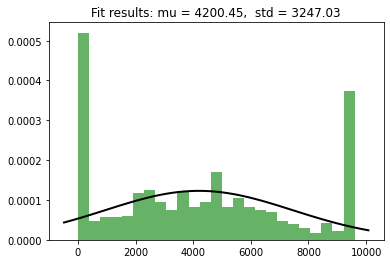

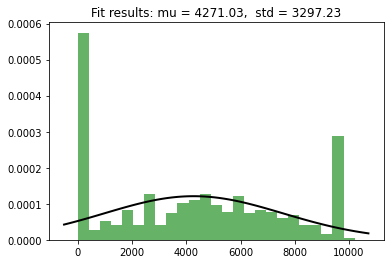

In [ ]:
# Last player as boundary = False
fitNormalDist(areaT2)
fitNormalDist(areaT1)

In [ ]:
def getMuStd(areaT):
    mu, std = norm.fit(areaT)
    return mu, std

In [ ]:
matchIDs = [int(iFile.split('.')[0]) for iFile in os.listdir(os.getcwd()) if 'json' in iFile]

In [ ]:
dfAreas = pd.DataFrame(columns=['Home team', 'Home score', 'Home area mean', 'Home area std', 'Away area std', 'Away area mean', 'Away score', 'Away team', 'Stage', 'Stage Id'])
for iMatchId in matchIDs:
    matchdata = loadJson(iMatchId)
    areaT1, areaT2 = getAreasForEachEvent(matchdata, lastPlayerAsBoundary=False)
    muT1, stdT1 = getMuStd(areaT1) # Likely away
    muT2, stdT2 = getMuStd(areaT2) # Likely home
    homeTeam = event360.matchInfo[iMatchId]['home_team']['home_team_name']
    awayTeam = event360.matchInfo[iMatchId]['away_team']['away_team_name']
    homescore = event360.matchInfo[iMatchId]['home_score']
    awayscore = event360.matchInfo[iMatchId]['away_score']
    stage = event360.matchInfo[iMatchId]['competition_stage']['name']
    stageid = event360.matchInfo[iMatchId]['competition_stage']['id']
    df = pd.DataFrame({'Home team': homeTeam , 'Home score': homescore, 'Home area mean': muT2, 'Home area std': stdT2, 'Away area std': stdT1, 'Away area mean': muT1, 'Away score': awayscore, 'Away team': awayTeam, 'Stage': stage, 'Stage Id': stageid}, index=[0])
    dfAreas = dfAreas.append(df, ignore_index=True)

In [ ]:
dfAreas.sort_values(by=['Stage Id'], inplace=True)
dfAreas

,Home team,Home score,Home area mean,Home area std,Away area std,Away area mean,Away score,Away team,Stage,Stage Id
15,WNT Finland,0,4645.413500,3375.182263,3335.324479,3966.481916,3,Germany Women's,Group Stage,10
28,France Women's,2,4400.900326,3518.801284,3499.645237,4349.383236,1,Belgium Women's,Group Stage,10
27,Austria Women's,2,4198.989164,3197.179424,3222.846516,4189.139352,0,Northern Ireland,Group Stage,10
26,Italy Women's,1,4746.679815,3549.376195,3433.166620,3798.886076,1,Iceland Women's,Group Stage,10
25,Austria Women's,1,4716.533865,3393.101988,3235.574461,3958.436022,0,Norway Women's,Group Stage,10
24,Switzerland Women's,1,4364.222915,3555.299299,3482.205222,4218.344710,4,Netherlands Women's,Group Stage,10
23,Italy Women's,0,4660.282481,3343.451746,3325.724298,3749.303369,1,Belgium Women's,Group Stage,10
22,Sweden Women's,5,4452.630530,3453.774567,3456.333189,4026.939624,0,Portugal Women's,Group Stage,10
21,Belgium Women's,1,4466.631466,3367.776035,3193.916696,4134.043579,1,Iceland Women's,Group Stage,10
20,Germany Women's,4,4914.873731,3547.865989,3436.869541,3681.278894,0,Denmark Women's,Group Stage,10


In [ ]:
def colorGreenOrange(row):    

    highlight1 = 'background-color: green;'
    highlight2 = 'background-color: orange;'
    default = ''

    # must return one string per cell in this row
    if row['Home score'] > row['Away score']:
        backColor = [highlight1, highlight2]
    elif row['Home score'] < row['Away score']:
        backColor = [highlight2, highlight1]
    else:
        backColor = [default, default]

    if row['Home area mean'] > row['Away area mean']:
        backColor += [highlight1, highlight2]
    else:
        backColor += [highlight2, highlight1]
    
    return backColor

dfAreas.style.apply(colorGreenOrange, subset=['Home score', 'Away score', 'Home area mean', 'Away area mean'], axis=1)

,Home team,Home score,Home area mean,Home area std,Away area std,Away area mean,Away score,Away team,Stage,Stage Id
15,WNT Finland,0,4645.413500,3375.182263,3335.324479,3966.481916,3,Germany Women's,Group Stage,10
28,France Women's,2,4400.900326,3518.801284,3499.645237,4349.383236,1,Belgium Women's,Group Stage,10
27,Austria Women's,2,4198.989164,3197.179424,3222.846516,4189.139352,0,Northern Ireland,Group Stage,10
26,Italy Women's,1,4746.679815,3549.376195,3433.166620,3798.886076,1,Iceland Women's,Group Stage,10
25,Austria Women's,1,4716.533865,3393.101988,3235.574461,3958.436022,0,Norway Women's,Group Stage,10
24,Switzerland Women's,1,4364.222915,3555.299299,3482.205222,4218.344710,4,Netherlands Women's,Group Stage,10
23,Italy Women's,0,4660.282481,3343.451746,3325.724298,3749.303369,1,Belgium Women's,Group Stage,10
22,Sweden Women's,5,4452.630530,3453.774567,3456.333189,4026.939624,0,Portugal Women's,Group Stage,10
21,Belgium Women's,1,4466.631466,3367.776035,3193.916696,4134.043579,1,Iceland Women's,Group Stage,10
20,Germany Women's,4,4914.873731,3547.865989,3436.869541,3681.278894,0,Denmark Women's,Group Stage,10


In [ ]:
#import seaborn as sns
#sns.distplot(areaT1, fit=norm, kde=False, color='g', bins=25)

In [ ]:
# Method 2 - Defense at left and attack at right regardless of team
for iEvent in matchdata.keys():
    (fig,ax) = createPitch(120,80,'yards','gray')
    if len(matchdata[iEvent]['eventLoc']) > 0:      
        if matchdata[iEvent]['period']==1:
            if matchdata[iEvent]['possession'] == 'home':
                x = matchdata[iEvent]['eventLoc'][0]
                y = matchdata[iEvent]['eventLoc'][1]
                positionBall = plt.Circle((x,y),2,color="black")
                ax.add_patch(positionBall)

                for i in range(len(matchdata[iEvent]['homeLoc'])):
                    x=matchdata[iEvent]['homeLoc'][i][0]
                    y=matchdata[iEvent]['homeLoc'][i][1]
                    position = plt.Circle((x,y),2,color="red")
                    ax.add_patch(position)

                for j in range(len(matchdata[iEvent]['awayLoc'])):
                    x=matchdata[iEvent]['awayLoc'][j][0]
                    y=matchdata[iEvent]['awayLoc'][j][1]
                    position = plt.Circle((x,y),2,color="blue")
                    ax.add_patch(position)
            else:
                x = matchdata[iEvent]['eventLoc'][0]
                y = matchdata[iEvent]['eventLoc'][1]
                positionBall = plt.Circle((120-x,y),2,color="black")
                ax.add_patch(positionBall)

                for i in range(len(matchdata[iEvent]['homeLoc'])):
                    x=matchdata[iEvent]['homeLoc'][i][0]
                    y=matchdata[iEvent]['homeLoc'][i][1]
                    position = plt.Circle((120-x,y),2,color="red")
                    ax.add_patch(position)

                for j in range(len(matchdata[iEvent]['awayLoc'])):
                    x=matchdata[iEvent]['awayLoc'][j][0]
                    y=matchdata[iEvent]['awayLoc'][j][1]
                    position = plt.Circle((120-x,y),2,color="blue")
                    ax.add_patch(position)
                
        else:
            if matchdata[iEvent]['possession'] == 'home':
                x = matchdata[iEvent]['eventLoc'][0]
                y = matchdata[iEvent]['eventLoc'][1]
                positionBall = plt.Circle((120-x,y),2,color="black")
                ax.add_patch(positionBall)

                for i in range(len(matchdata[iEvent]['homeLoc'])):
                    x=matchdata[iEvent]['homeLoc'][i][0]
                    y=matchdata[iEvent]['homeLoc'][i][1]
                    position = plt.Circle((120-x,y),2,color="red")
                    ax.add_patch(position)

                for j in range(len(matchdata[iEvent]['awayLoc'])):
                    x=matchdata[iEvent]['awayLoc'][j][0]
                    y=matchdata[iEvent]['awayLoc'][j][1]
                    position = plt.Circle((120-x,y),2,color="blue")
                    ax.add_patch(position)
            else:
                x = matchdata[iEvent]['eventLoc'][0]
                y = matchdata[iEvent]['eventLoc'][1]
                positionBall = plt.Circle((x,y),2,color="black")
                ax.add_patch(positionBall)

                for i in range(len(matchdata[iEvent]['homeLoc'])):
                    x=matchdata[iEvent]['homeLoc'][i][0]
                    y=matchdata[iEvent]['homeLoc'][i][1]
                    position = plt.Circle((x,y),2,color="red")
                    ax.add_patch(position)

                for j in range(len(matchdata[iEvent]['awayLoc'])):
                    x=matchdata[iEvent]['awayLoc'][j][0]
                    y=matchdata[iEvent]['awayLoc'][j][1]
                    position = plt.Circle((x,y),2,color="blue")
                    ax.add_patch(position)

    fig.set_size_inches(10, 7)
    plt.show()


In [ ]:
event360.matchInfo[iMatchId]

{'match_id': 3845506,
 'match_date': '2022-07-26',
 'kick_off': '21:00:00.000',
 'competition': {'competition_id': 53,
  'country_name': 'Europe',
  'competition_name': "UEFA Women's Euro"},
 'season': {'season_id': 106, 'season_name': '2022'},
 'home_team': {'home_team_id': 865,
  'home_team_name': "England Women's",
  'home_team_gender': 'female',
  'home_team_group': None,
  'country': {'id': 68, 'name': 'England'},
  'managers': [{'id': 45,
    'name': 'Sarina Glotzbach-Wiegman',
    'nickname': 'Sarina Wiegman',
    'dob': '1969-10-26',
    'country': {'id': 160, 'name': 'Netherlands'}}]},
 'away_team': {'away_team_id': 858,
  'away_team_name': "Sweden Women's",
  'away_team_gender': 'female',
  'away_team_group': None,
  'country': {'id': 220, 'name': 'Sweden'},
  'managers': [{'id': 3016,
    'name': 'Peter Gerhardsson',
    'nickname': None,
    'dob': '1959-08-22',
    'country': {'id': 220, 'name': 'Sweden'}}]},
 'home_score': 4,
 'away_score': 0,
 'match_status': 'available'

# First find which team has the actual possession and for how long.

In [ ]:
def number_of_events(defObject = event360, defMatchId = 3847567):
    underPressureCounts = 0
    typesCounts = 0
    typesList = list()
    eventTypeDict = dict()
    events = defObject.matchEvents[defMatchId]
    for iEvent in events:
        if 'under_pressure' in events[iEvent].keys():
            underPressureCounts += 1
        if 'type' in events[iEvent].keys():
            if events[iEvent]['type']['name'] not in typesList:
                print(events[iEvent])
                eventTypeDict[events[iEvent]['type']['name']] = input()
                clear_output()
            typesList.append(events[iEvent]['type']['name'])
            typesCounts += 1

    print(len(events))
    print(underPressureCounts)
    print(typesCounts)
    return eventTypeDict

eventTypeDict = number_of_events()
# 0 is same team and 1 is opponent, 2 is ne

In [ ]:
def loadEventTypeDict():
    filename = 'eventTypeDict' + '.json'
    with open(filename, 'r') as fh:
        eventTypeDict = json.load(fh)
    fh.close()
    return eventTypeDict

eventTypeDict = loadEventTypeDict() #When needed

In [ ]:
eventTypeDict

{'Starting XI': 'Neutral',
 'Half Start': 'Neutral',
 'Pass': 'Same',
 'Ball Receipt*': 'Same',
 'Duel': 'Mix',
 'Clearance': 'Opp',
 'Pressure': 'Mix',
 'Ball Recovery': 'Mix',
 'Carry': 'Same',
 'Miscontrol': 'Opp',
 'Interception': 'Opp',
 'Dispossessed': 'Opp',
 'Dribble': 'Mix',
 'Dribbled Past': 'Opp',
 'Shot': 'Same',
 'Goal Keeper': 'Mix',
 'Block': 'Opp',
 'Foul Committed': 'Opp',
 'Foul Won': 'Same',
 'Offside': 'Opp',
 'Injury Stoppage': 'Neutral',
 '50/50': 'Mix',
 'Half End': 'Neutral',
 'Substitution': 'Neutral',
 'Tactical Shift': 'Neutral',
 'Player Off': 'Neutral',
 'Player On': 'Neutral',
 'Error': 'Opp',
 'Bad Behaviour': 'Neutral'}

In [ ]:
# Only once stores event type dict in json for reuse
#fileName = 'eventTypeDict' + '.json'
#with open(fileName, 'w') as fh:
#    json.dump(eventTypeDict, fh)

In [ ]:
def getTypesWithUnderPressure(defObject = event360, defMatchId = 3847567, eventTypeDict = eventTypeDict):
    events = defObject.matchEvents[defMatchId]
    typesWithUnderPressure = dict()
    typesWithUnderPressure = {iKey: {jkey: defaultdict(int) for jkey in ['under_pressure', 'other']}  for iKey in set(eventTypeDict.values()) }
    for iEvent in events:
        if 'type' in events[iEvent].keys():
            if 'under_pressure' in events[iEvent].keys():
                typesWithUnderPressure[eventTypeDict[events[iEvent]['type']['name']]]['under_pressure'][events[iEvent]['type']['name']] += 1
            else:
                typesWithUnderPressure[eventTypeDict[events[iEvent]['type']['name']]]['other'][events[iEvent]['type']['name']] += 1
    return typesWithUnderPressure

typesWithUnderPressure = getTypesWithUnderPressure()

In [ ]:
typesWithUnderPressure

{'Opp': {'under_pressure': defaultdict(int,
              {'Clearance': 58,
               'Miscontrol': 4,
               'Dispossessed': 44,
               'Foul Committed': 1,
               'Interception': 2}),
  'other': defaultdict(int,
              {'Miscontrol': 32,
               'Interception': 33,
               'Dribbled Past': 23,
               'Block': 57,
               'Foul Committed': 41,
               'Offside': 1,
               'Error': 1})},
 'Mix': {'under_pressure': defaultdict(int,
              {'Duel': 104,
               'Ball Recovery': 24,
               'Pressure': 3,
               'Dribble': 35,
               '50/50': 2}),
  'other': defaultdict(int,
              {'Pressure': 403, 'Ball Recovery': 98, 'Goal Keeper': 39})},
 'Neutral': {'under_pressure': defaultdict(int, {}),
  'other': defaultdict(int,
              {'Starting XI': 2,
               'Half Start': 8,
               'Injury Stoppage': 5,
               'Half End': 8,
               '

In [ ]:
 #https://github.com/imrankhan17/statsbomb-parser


In [ ]:
def view_some_events(defObject = event360, defMatchId = 3847567):
    events = defObject.matchEvents[defMatchId]
    typesList = list()
    for iEvent in events:
        if 'type' in events[iEvent].keys():
            if events[iEvent]['type']['name'] not in typesList:
                print(events[iEvent])
            typesList.append(events[iEvent]['type']['name'])
    typesList = list()
    print('----------------------------------------------------------------------------------------------OUT--------------------------------------------')
    for iEvent in events:   
        if 'out' in events[iEvent].keys():
            if events[iEvent]['type']['name'] not in typesList:
                print(events[iEvent])

view_some_events()

In [ ]:
def getOtherId(homeId, awayId, currentId):
    if homeId == currentId:
        return awayId
    else:
        return homeId

In [ ]:
def updateDict(blueprintDict, homeId, awayId, teamId, keyTeamId, keyOtherId, durationCount, value):
    otherId = getOtherId(homeId, awayId, teamId)
    blueprintDict[teamId][keyTeamId][durationCount] += value
    blueprintDict[otherId][keyOtherId][durationCount] += value
    return blueprintDict

In [ ]:
def checkSameRules(homeId, awayId, iEvent, defObject = event360, defMatchId = 3847567, eventTypeDict = eventTypeDict):
    events = defObject.matchEvents[defMatchId]
    eventTypeName = events[iEvent]['type']['name']
    underPressure = False

    blueprintDict = dict()
    blueprintDict[homeId] = dict()
    blueprintDict[awayId] = dict()
    blueprintDict[homeId]['successPress'] = dict()
    blueprintDict[homeId]['failedPress'] = dict()
    blueprintDict[homeId]['successEvadedPress'] = dict()
    blueprintDict[homeId]['failedEvadedPress'] = dict()
    blueprintDict[awayId]['successPress'] = dict()
    blueprintDict[awayId]['failedPress'] = dict()
    blueprintDict[awayId]['successEvadedPress'] = dict()
    blueprintDict[awayId]['failedEvadedPress'] = dict()

    blueprintDict[homeId]['successPress']['duration'] = 0
    blueprintDict[homeId]['successPress']['counts'] = 0
    blueprintDict[homeId]['failedPress']['duration'] = 0
    blueprintDict[homeId]['failedPress']['counts'] = 0
    blueprintDict[homeId]['successEvadedPress']['duration'] = 0
    blueprintDict[homeId]['successEvadedPress']['counts'] = 0
    blueprintDict[homeId]['failedEvadedPress']['duration'] = 0
    blueprintDict[homeId]['failedEvadedPress']['counts'] = 0

    blueprintDict[awayId]['successPress']['duration'] = 0
    blueprintDict[awayId]['successPress']['counts'] = 0
    blueprintDict[awayId]['failedPress']['duration'] = 0
    blueprintDict[awayId]['failedPress']['counts'] = 0
    blueprintDict[awayId]['successEvadedPress']['duration'] = 0
    blueprintDict[awayId]['successEvadedPress']['counts'] = 0
    blueprintDict[awayId]['failedEvadedPress']['duration'] = 0
    blueprintDict[awayId]['failedEvadedPress']['counts'] = 0


    if 'under_pressure' in events[iEvent].keys():
        underPressure = True
        if eventTypeName == 'Carry':
            if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                durationEvent = events[iEvent]['duration']
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
            else:
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)

        elif eventTypeName == 'Ball Receipt*':
            if eventTypeName in events[iEvent].keys():
                if 'outcome' in events[iEvent][eventTypeName]:
                    if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                        durationEvent = events[iEvent]['duration']
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'duration', durationEvent)
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)
                    else:
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)
                else:
                    if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                        durationEvent = events[iEvent]['duration']
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                    else:
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
            else:
              if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                  durationEvent = events[iEvent]['duration']
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
              else:
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
        
        elif eventTypeName == 'Pass':
            eventTypeName = 'pass' # because of data
            if eventTypeName in events[iEvent].keys():
                if 'outcome' in events[iEvent][eventTypeName]:
                    if events[iEvent][eventTypeName]['outcome']['id'] in [9, 75, 76]:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)
                    else:
                        pass        
                else:
                    if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                        durationEvent = events[iEvent]['duration']
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                    else:
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                        
            else:
              if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                  durationEvent = events[iEvent]['duration']
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
              else:
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)

        elif eventTypeName == 'Foul Won':
            if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                durationEvent = events[iEvent]['duration']
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
            else:
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)

        elif eventTypeName == 'Shot':
            eventTypeName = 'shot' # because of data
            if eventTypeName in events[iEvent].keys():
                if 'outcome' in events[iEvent][eventTypeName]:
                    if events[iEvent][eventTypeName]['outcome']['id'] in [96, 98, 101, 115]:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)
                    else:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1) 
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)        
                else:
                    if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                        durationEvent = events[iEvent]['duration']
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                    else:
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                        
            else:
              if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                  durationEvent = events[iEvent]['duration']
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
              else:
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)

    return blueprintDict

In [ ]:
def updateFromDictAtoDictB(dictA, dictB):
    for iKey in dictA.keys():
        for jKey in dictA[iKey].keys():
            for kKey in dictA[iKey][jKey].keys():
                dictA[iKey][jKey][kKey] += dictB[iKey][jKey][kKey]
    return dictA

In [ ]:
def checkOppRules(homeId, awayId, iEvent, iEventIndex, defObject = event360, defMatchId = 3847567, eventTypeDict = eventTypeDict):
    events = defObject.matchEvents[defMatchId]
    eventTypeName = events[iEvent]['type']['name']
    underPressure = False

    blueprintDict = dict()
    blueprintDict[homeId] = dict()
    blueprintDict[awayId] = dict()
    blueprintDict[homeId]['successPress'] = dict()
    blueprintDict[homeId]['failedPress'] = dict()
    blueprintDict[homeId]['successEvadedPress'] = dict()
    blueprintDict[homeId]['failedEvadedPress'] = dict()
    blueprintDict[awayId]['successPress'] = dict()
    blueprintDict[awayId]['failedPress'] = dict()
    blueprintDict[awayId]['successEvadedPress'] = dict()
    blueprintDict[awayId]['failedEvadedPress'] = dict()

    blueprintDict[homeId]['successPress']['duration'] = 0
    blueprintDict[homeId]['successPress']['counts'] = 0
    blueprintDict[homeId]['failedPress']['duration'] = 0
    blueprintDict[homeId]['failedPress']['counts'] = 0
    blueprintDict[homeId]['successEvadedPress']['duration'] = 0
    blueprintDict[homeId]['successEvadedPress']['counts'] = 0
    blueprintDict[homeId]['failedEvadedPress']['duration'] = 0
    blueprintDict[homeId]['failedEvadedPress']['counts'] = 0

    blueprintDict[awayId]['successPress']['duration'] = 0
    blueprintDict[awayId]['successPress']['counts'] = 0
    blueprintDict[awayId]['failedPress']['duration'] = 0
    blueprintDict[awayId]['failedPress']['counts'] = 0
    blueprintDict[awayId]['successEvadedPress']['duration'] = 0
    blueprintDict[awayId]['successEvadedPress']['counts'] = 0
    blueprintDict[awayId]['failedEvadedPress']['duration'] = 0
    blueprintDict[awayId]['failedEvadedPress']['counts'] = 0


    if 'under_pressure' in events[iEvent].keys():
        underPressure = True
        if eventTypeName == 'Clearance':
            foundNext, pressFailed = getLocationDifference(homeId, awayId, iEvent, iEventIndex, defObject, defMatchId, eventTypeDict)
            if foundNext is True:
                if pressFailed is True:
                    if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                        durationEvent = events[iEvent]['duration']
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'duration', durationEvent)
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'counts', 1)
                    else:
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'counts', 1)
                else:
                    if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                        durationEvent = events[iEvent]['duration']
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'duration', durationEvent)
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'counts', 1)
                    else:
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'counts', 1)

        elif eventTypeName == 'Miscontrol':
            if eventTypeName in events[iEvent].keys():
                foundNext, pressFailed = getPressStatusMiscontrol(homeId, awayId, iEvent, iEventIndex, defObject, defMatchId, eventTypeDict)
                if foundNext is True:
                    if pressFailed is True:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                    else:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)
        
        elif eventTypeName == 'Dispossessed':
            dispossessorId = getOtherId(homeId, awayId, events[iEvent]['team']['id'])
            if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                durationEvent = events[iEvent]['duration']
                blueprintDict = updateDict(blueprintDict, homeId, awayId, dispossessorId, 'failedEvadedPress', 'successPress', 'duration', durationEvent)
                blueprintDict = updateDict(blueprintDict, homeId, awayId, dispossessorId, 'failedEvadedPress', 'successPress', 'counts', 1)
            else:
                blueprintDict = updateDict(blueprintDict, homeId, awayId, dispossessorId, 'failedEvadedPress', 'successPress', 'counts', 1)
            

        elif eventTypeName == 'Foul Committed':
            if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                durationEvent = events[iEvent]['duration']
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'duration', durationEvent)
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'counts', 1)
            else:
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'counts', 1)

        elif eventTypeName == 'Interception':
            eventTypeName = 'interception' # because of data
            if eventTypeName in events[iEvent].keys():
                if 'outcome' in events[iEvent][eventTypeName]:
                    if events[iEvent][eventTypeName]['outcome']['id'] in [15, 16, 17, 4]:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'counts', 1)
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'counts', 1)
                    else:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'counts', 1)   
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'counts', 1)        
                else:
                    pass
                        
            else:
              pass

    return blueprintDict

In [ ]:
def getLocationDifference(homeId, awayId, iEvent, iEventIndex, defObject = event360, defMatchId = 3847567, eventTypeDict = eventTypeDict):
    events = defObject.matchEvents[defMatchId]
    eventTypeName = events[iEvent]['type']['name']
    foundNext = False
    pressFailed = False
    dangerXLoc = 0
    dangerYLoc = 40

    if 'location' in events[iEvent].keys():
        currentXLoc, currentYLoc = events[iEvent]['location']
        currentTeamId = events[iEvent]['team']['id']
        currentPeriod = events[iEvent]['period']

    while True:
        foundNext = False
        if iEventIndex < len(list(events.keys())) - 1:
            nextEventId = list(events)[iEventIndex + 1]
            if events[nextEventId]['period'] == currentPeriod:
                if 'location' in events[nextEventId].keys():
                    foundNext = True
                    nextXLoc, nextYLoc = events[nextEventId]['location']
                    nextTeamId = events[nextEventId]['team']['id']
                    if nextTeamId != currentTeamId:
                        nextXLoc = 120 - nextXLoc
                        nextYLoc = 80 - nextYLoc
                    break

                else:
                    iEventIndex += 1
                    continue

            else:
                break

        else:
            break
  
    if foundNext == True:
        currentDist = (currentXLoc - dangerXLoc)**2 + (currentYLoc - dangerYLoc)**2
        nextDist = (nextXLoc - dangerXLoc)**2 + (nextYLoc - dangerYLoc)**2
        if currentDist > nextDist:
            pressFailed = True

    return foundNext, pressFailed

In [ ]:
def getPressStatusMiscontrol(homeId, awayId, iEvent, iEventIndex, defObject = event360, defMatchId = 3847567, eventTypeDict = eventTypeDict):
    events = defObject.matchEvents[defMatchId]
    eventTypeName = events[iEvent]['type']['name']
    foundNext = False
    pressFailed = False
    dangerXLoc = 0
    dangerYLoc = 40

    if 'location' in events[iEvent].keys():
        currentTeamId = events[iEvent]['team']['id']
        currentPeriod = events[iEvent]['period']

    while True:
        foundNext = False
        if iEventIndex < len(list(events.keys())) - 1:
            nextEventId = list(events)[iEventIndex + 1]
            if events[nextEventId]['period'] == currentPeriod:
                if 'type' in events[nextEventId].keys() and events[nextEventId]['type']['name'] == 'Pressure':
                    iEventIndex += 1
                    continue

                elif 'type' in events[nextEventId].keys() and events[nextEventId]['type']['name'] == 'Dispossessed':
                    nextTeamId = getOtherId(homeId, awayId, events[nextEventId]['team']['id'])
                    iEventIndex += 1
                    continue

                if 'location' in events[nextEventId].keys():
                    foundNext = True
                    nextTeamId = events[nextEventId]['team']['id']
                    break

                else:
                    iEventIndex += 1
                    continue

            else:
                break

        else:
            break
  
    if foundNext == True:
        if nextTeamId == currentTeamId:
            pressFailed = True

    return foundNext, pressFailed

In [ ]:
def checkMixRules(homeId, awayId, iEvent, iEventIndex, defObject = event360, defMatchId = 3847567, eventTypeDict = eventTypeDict):
    events = defObject.matchEvents[defMatchId]
    eventTypeName = events[iEvent]['type']['name']
    underPressure = False

    blueprintDict = dict()
    blueprintDict[homeId] = dict()
    blueprintDict[awayId] = dict()
    blueprintDict[homeId]['successPress'] = dict()
    blueprintDict[homeId]['failedPress'] = dict()
    blueprintDict[homeId]['successEvadedPress'] = dict()
    blueprintDict[homeId]['failedEvadedPress'] = dict()
    blueprintDict[awayId]['successPress'] = dict()
    blueprintDict[awayId]['failedPress'] = dict()
    blueprintDict[awayId]['successEvadedPress'] = dict()
    blueprintDict[awayId]['failedEvadedPress'] = dict()

    blueprintDict[homeId]['successPress']['duration'] = 0
    blueprintDict[homeId]['successPress']['counts'] = 0
    blueprintDict[homeId]['failedPress']['duration'] = 0
    blueprintDict[homeId]['failedPress']['counts'] = 0
    blueprintDict[homeId]['successEvadedPress']['duration'] = 0
    blueprintDict[homeId]['successEvadedPress']['counts'] = 0
    blueprintDict[homeId]['failedEvadedPress']['duration'] = 0
    blueprintDict[homeId]['failedEvadedPress']['counts'] = 0

    blueprintDict[awayId]['successPress']['duration'] = 0
    blueprintDict[awayId]['successPress']['counts'] = 0
    blueprintDict[awayId]['failedPress']['duration'] = 0
    blueprintDict[awayId]['failedPress']['counts'] = 0
    blueprintDict[awayId]['successEvadedPress']['duration'] = 0
    blueprintDict[awayId]['successEvadedPress']['counts'] = 0
    blueprintDict[awayId]['failedEvadedPress']['duration'] = 0
    blueprintDict[awayId]['failedEvadedPress']['counts'] = 0


    if 'under_pressure' in events[iEvent].keys():
        underPressure = True
        if eventTypeName == '50/50':
            eventTypeName = '50-50' # because of data
            if eventTypeName in events[iEvent].keys():
                if 'outcome' in events[iEvent][eventTypeName]:
                    if events[iEvent][eventTypeName]['outcome']['id'] in [108, 147]:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedPress', 'counts', 1)
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedPress', 'counts', 1)
                    else:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successPress', 'counts', 1)     
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successPress', 'counts', 1)        
                else:
                    pass
                        
            else:
              pass

        elif eventTypeName == 'Dribble':
            eventTypeName = 'dribble' # because of data
            if eventTypeName in events[iEvent].keys():
                if 'outcome' in events[iEvent][eventTypeName]:
                    if events[iEvent][eventTypeName]['outcome']['id'] in [8]:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                    else:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)  
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)        
                else:
                    pass
                        
            else:
              pass
        
        elif eventTypeName == 'Pressure':
            pass            

        elif eventTypeName == 'Ball Recovery':
            if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                durationEvent = events[iEvent]['duration']
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
            else:
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)

        elif eventTypeName == 'Duel':
            eventTypeName = 'duel' # because of data
            if eventTypeName in events[iEvent].keys():
                if 'outcome' in events[iEvent][eventTypeName]:
                    if events[iEvent][eventTypeName]['outcome']['id'] in [4, 15, 16, 17]:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'counts', 1)
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'counts', 1)
                    else:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'counts', 1)  
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'counts', 1)        
                else:
                    pass
                        
            else:
              pass

    return blueprintDict

In [ ]:
def getPressStatsFn(defObject = event360, defMatchId = 3847567, eventTypeDict = eventTypeDict):
    events = defObject.matchEvents[defMatchId]
    homeId = defObject.matchInfo[defMatchId]['home_team']['home_team_id']
    awayId = defObject.matchInfo[defMatchId]['away_team']['away_team_id']
    
    getPressStats = dict()
    getPressStats[homeId] = dict()   # Home team id
    getPressStats[awayId] = dict()   # Away team id

    getPressStats[homeId]['successPress'] = dict()
    getPressStats[homeId]['failedPress'] = dict()
    getPressStats[homeId]['successEvadedPress'] = dict()
    getPressStats[homeId]['failedEvadedPress'] = dict()
    getPressStats[awayId]['successPress'] = dict()
    getPressStats[awayId]['failedPress'] = dict()
    getPressStats[awayId]['successEvadedPress'] = dict()
    getPressStats[awayId]['failedEvadedPress'] = dict()

    getPressStats[homeId]['successPress']['duration'] = 0
    getPressStats[homeId]['successPress']['counts'] = 0
    getPressStats[homeId]['failedPress']['duration'] = 0
    getPressStats[homeId]['failedPress']['counts'] = 0
    getPressStats[homeId]['successEvadedPress']['duration'] = 0
    getPressStats[homeId]['successEvadedPress']['counts'] = 0
    getPressStats[homeId]['failedEvadedPress']['duration'] = 0
    getPressStats[homeId]['failedEvadedPress']['counts'] = 0

    getPressStats[awayId]['successPress']['duration'] = 0
    getPressStats[awayId]['successPress']['counts'] = 0
    getPressStats[awayId]['failedPress']['duration'] = 0
    getPressStats[awayId]['failedPress']['counts'] = 0
    getPressStats[awayId]['successEvadedPress']['duration'] = 0
    getPressStats[awayId]['successEvadedPress']['counts'] = 0
    getPressStats[awayId]['failedEvadedPress']['duration'] = 0
    getPressStats[awayId]['failedEvadedPress']['counts'] = 0


    eventCounter = 0
    for iEventIndex, iEvent in enumerate(events):
        if 'type' in events[iEvent].keys():
            # skip the neutral type
            eventTypeName = events[iEvent]['type']['name']
            if eventTypeName in eventTypeDict.keys():
                if eventTypeDict[eventTypeName] == 'Neutral':
                    continue
                elif eventTypeDict[eventTypeName] == 'Same':
                    someDict = checkSameRules(homeId, awayId, iEvent, defObject, defMatchId, eventTypeDict)
                    getPressStats = updateFromDictAtoDictB(getPressStats, someDict.copy())
                elif eventTypeDict[eventTypeName] == 'Opp':
                    someDict = checkOppRules(homeId, awayId, iEvent, iEventIndex, defObject, defMatchId, eventTypeDict)
                    getPressStats = updateFromDictAtoDictB(getPressStats, someDict.copy())
                elif eventTypeDict[eventTypeName] == 'Mix':
                    someDict = checkMixRules(homeId, awayId, iEvent, iEventIndex, defObject, defMatchId, eventTypeDict)
                    getPressStats = updateFromDictAtoDictB(getPressStats, someDict.copy())
                else:
                    continue


    getPressStats[homeId]['teamname'] = defObject.matchInfo[defMatchId]['home_team']['home_team_name']
    getPressStats[awayId]['teamname'] = defObject.matchInfo[defMatchId]['away_team']['away_team_name']
    return getPressStats[homeId]['successEvadedPress']['duration'] + getPressStats[homeId]['successPress']['duration'], getPressStats[awayId]['successEvadedPress']['duration'] + getPressStats[awayId]['successPress']['duration'], getPressStats[homeId]['successEvadedPress']['counts'] + getPressStats[homeId]['successPress']['counts'], getPressStats[awayId]['successEvadedPress']['counts'] + getPressStats[homeId]['successPress']['counts']

#getPressStats = getPressStatsFn()
  


In [ ]:
getPressStats

(284, 270)

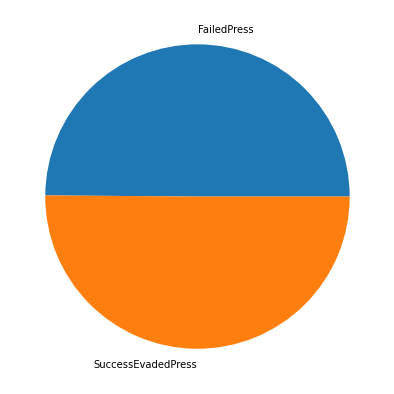

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
 
pies = ['FailedPress', 'SuccessEvadedPress']
data = [339.633, 341.270]
fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = pies)
plt.show()

In [ ]:
#getPressStats = getPressStatsFn(defMatchId = 3835341)

In [ ]:
getPressStats

{855: {'successPress': {'duration': 34.045840000000005, 'counts': 0},
  'failedPress': {'duration': 267.138608, 'counts': 39},
  'successEvadedPress': {'duration': 390.2772310019997, 'counts': 38},
  'failedEvadedPress': {'duration': 31.219932999999994, 'counts': 0},
  'teamname': "Italy Women's"},
 854: {'successPress': {'duration': 31.219932999999994, 'counts': 0},
  'failedPress': {'duration': 390.2772310019997, 'counts': 38},
  'successEvadedPress': {'duration': 267.138608, 'counts': 39},
  'failedEvadedPress': {'duration': 34.045840000000005, 'counts': 0},
  'teamname': "Belgium Women's"}}

In [ ]:
matchIDs = [int(iFile.split('.')[0]) for iFile in os.listdir(os.getcwd()) if 'json' in iFile and iFile[0].isnumeric()]
dfPress = pd.DataFrame(columns=['Home team', 'Home score', 'Home success evaded press', 'Home success press counts', 'Away success press counts', 'Away success evaded press', 'Away score', 'Away team', 'Stage', 'Stage Id'])
for iMatchId in matchIDs:
    matchdata = loadJson(iMatchId)
    homeSuccessEvaded, awaySuccessEvaded, homeSuccessEvadedCounts, awaySuccessEvadedCounts = getPressStatsFn(defMatchId = iMatchId)
    homeSuccessEvaded = round(homeSuccessEvaded, 4)
    awaySuccessEvaded = round(awaySuccessEvaded, 4)
    homeTeam = event360.matchInfo[iMatchId]['home_team']['home_team_name']
    awayTeam = event360.matchInfo[iMatchId]['away_team']['away_team_name']
    homescore = event360.matchInfo[iMatchId]['home_score']
    awayscore = event360.matchInfo[iMatchId]['away_score']
    stage = event360.matchInfo[iMatchId]['competition_stage']['name']
    stageid = event360.matchInfo[iMatchId]['competition_stage']['id']
    df = pd.DataFrame({'Home team': homeTeam , 'Home score': homescore, 'Home success evaded press': homeSuccessEvaded, 'Home success press counts': homeSuccessEvadedCounts, 'Away success press counts': awaySuccessEvadedCounts, 'Away success evaded press': awaySuccessEvaded, 'Away score': awayscore, 'Away team': awayTeam, 'Stage': stage, 'Stage Id': stageid}, index=[0])
    dfPress = dfPress.append(df, ignore_index=True)

In [ ]:
dfPress.sort_values(by=['Stage Id'], inplace=True)
dfPress

,Home team,Home score,Home success evaded press,Home success press counts,Away success press counts,Away success evaded press,Away score,Away team,Stage,Stage Id
0,Sweden Women's,2,312.2904,322,293,295.6518,1,Switzerland Women's,Group Stage,10
28,France Women's,2,398.4536,367,233,221.3216,1,Belgium Women's,Group Stage,10
27,Austria Women's,2,331.4891,279,192,201.4325,0,Northern Ireland,Group Stage,10
26,Italy Women's,1,384.4845,330,261,223.1677,1,Iceland Women's,Group Stage,10
25,Austria Women's,1,398.4526,349,383,354.4709,0,Norway Women's,Group Stage,10
24,Switzerland Women's,1,363.4705,360,362,411.4953,4,Netherlands Women's,Group Stage,10
23,Sweden Women's,5,233.8320,285,301,328.5421,0,Portugal Women's,Group Stage,10
22,Belgium Women's,1,284.9656,272,315,302.7456,1,Iceland Women's,Group Stage,10
21,Italy Women's,0,428.0108,314,265,303.2181,1,Belgium Women's,Group Stage,10
20,England Women's,8,370.9033,304,165,208.6023,0,Norway Women's,Group Stage,10


In [ ]:
dfPress.sort_values(by=['Stage Id'], inplace=True)
dfPress

,Home team,Home score,Home success evaded press,Away success evaded press,Away score,Away team,Stage,Stage Id
0,Portugal Women's,2,291.2503,199.9305,2,Switzerland Women's,Group Stage,10
28,France Women's,2,362.8181,196.2599,1,Belgium Women's,Group Stage,10
27,Austria Women's,2,297.9525,182.0671,0,Northern Ireland,Group Stage,10
26,Italy Women's,1,340.6656,191.3250,1,Iceland Women's,Group Stage,10
25,Austria Women's,1,350.0787,305.5859,0,Norway Women's,Group Stage,10
24,Switzerland Women's,1,323.3786,375.6199,4,Netherlands Women's,Group Stage,10
23,Sweden Women's,5,205.4988,298.0595,0,Portugal Women's,Group Stage,10
22,Belgium Women's,1,226.2767,267.8721,1,Iceland Women's,Group Stage,10
21,Italy Women's,0,390.2772,267.1386,1,Belgium Women's,Group Stage,10
20,England Women's,8,354.0429,175.4456,0,Norway Women's,Group Stage,10


In [ ]:
def colorGreenOrange(row):    

    highlight1 = 'background-color: green;'
    highlight2 = 'background-color: orange;'
    highlight3 = 'background-color: red;'
    default = ''

    # must return one string per cell in this row
    if row['Home team'] == "England Women's" or row['Away team'] == "England Women's":
        backColor = [highlight3, highlight3]
    else:
        backColor = [default, default]

    if row['Home score'] > row['Away score']:
        backColor += [highlight1, highlight2]
    elif row['Home score'] < row['Away score']:
        backColor += [highlight2, highlight1]
    else:
        backColor += [default, default]

    if row['Home success evaded press'] > row['Away success evaded press']:
        backColor += [highlight1, highlight2]
    else:
        backColor += [highlight2, highlight1]
    
    return backColor

dfPress.style.apply(colorGreenOrange, subset=['Home team', 'Away team', 'Home score', 'Away score', 'Home success evaded press', 'Away success evaded press'], axis=1)

,Home team,Home score,Home success evaded press,Home success press counts,Away success press counts,Away success evaded press,Away score,Away team,Stage,Stage Id
0,Sweden Women's,2,312.290400,322,293,295.651800,1,Switzerland Women's,Group Stage,10
28,France Women's,2,398.453600,367,233,221.321600,1,Belgium Women's,Group Stage,10
27,Austria Women's,2,331.489100,279,192,201.432500,0,Northern Ireland,Group Stage,10
26,Italy Women's,1,384.484500,330,261,223.167700,1,Iceland Women's,Group Stage,10
25,Austria Women's,1,398.452600,349,383,354.470900,0,Norway Women's,Group Stage,10
24,Switzerland Women's,1,363.470500,360,362,411.495300,4,Netherlands Women's,Group Stage,10
23,Sweden Women's,5,233.832000,285,301,328.542100,0,Portugal Women's,Group Stage,10
22,Belgium Women's,1,284.965600,272,315,302.745600,1,Iceland Women's,Group Stage,10
21,Italy Women's,0,428.010800,314,265,303.218100,1,Belgium Women's,Group Stage,10
20,England Women's,8,370.903300,304,165,208.602300,0,Norway Women's,Group Stage,10


In [ ]:
def colorGreenOrange(row):    

    highlight1 = 'background-color: green;'
    highlight2 = 'background-color: orange;'
    highlight3 = 'background-color: red;'
    default = ''

    # must return one string per cell in this row
    if row['Home team'] == "England Women's" or row['Away team'] == "England Women's":
        backColor = [highlight3, highlight3]
    else:
        backColor = [default, default]

    if row['Home score'] > row['Away score']:
        backColor += [highlight1, highlight2]
    elif row['Home score'] < row['Away score']:
        backColor += [highlight2, highlight1]
    else:
        backColor += [default, default]

    if row['Home success press counts'] > row['Away success press counts']:
        backColor += [highlight1, highlight2]
    else:
        backColor += [highlight2, highlight1]
    
    return backColor

dfPress.style.apply(colorGreenOrange, subset=['Home team', 'Away team', 'Home score', 'Away score', 'Home success press counts', 'Away success press counts'], axis=1)

,Home team,Home score,Home success evaded press,Home success press counts,Away success press counts,Away success evaded press,Away score,Away team,Stage,Stage Id
0,Sweden Women's,2,312.290400,322,293,295.651800,1,Switzerland Women's,Group Stage,10
28,France Women's,2,398.453600,367,233,221.321600,1,Belgium Women's,Group Stage,10
27,Austria Women's,2,331.489100,279,192,201.432500,0,Northern Ireland,Group Stage,10
26,Italy Women's,1,384.484500,330,261,223.167700,1,Iceland Women's,Group Stage,10
25,Austria Women's,1,398.452600,349,383,354.470900,0,Norway Women's,Group Stage,10
24,Switzerland Women's,1,363.470500,360,362,411.495300,4,Netherlands Women's,Group Stage,10
23,Sweden Women's,5,233.832000,285,301,328.542100,0,Portugal Women's,Group Stage,10
22,Belgium Women's,1,284.965600,272,315,302.745600,1,Iceland Women's,Group Stage,10
21,Italy Women's,0,428.010800,314,265,303.218100,1,Belgium Women's,Group Stage,10
20,England Women's,8,370.903300,304,165,208.602300,0,Norway Women's,Group Stage,10


In [ ]:
def colorGreenOrange(row):    

    highlight1 = 'background-color: green;'
    highlight2 = 'background-color: orange;'
    default = ''

    # must return one string per cell in this row
    if row['Home score'] > row['Away score']:
        backColor = [highlight1, highlight2]
    elif row['Home score'] < row['Away score']:
        backColor = [highlight2, highlight1]
    else:
        backColor = [default, default]

    if row['Home success evaded press'] > row['Away success evaded press']:
        backColor += [highlight1, highlight2]
    else:
        backColor += [highlight2, highlight1]
    
    return backColor

dfPress.style.apply(colorGreenOrange, subset=['Home score', 'Away score', 'Home success evaded press', 'Away success evaded press'], axis=1)

,Home team,Home score,Home success evaded press,Away success evaded press,Away score,Away team,Stage,Stage Id
0,Portugal Women's,2,291.250300,199.930500,2,Switzerland Women's,Group Stage,10
28,France Women's,2,362.818100,196.259900,1,Belgium Women's,Group Stage,10
27,Austria Women's,2,297.952500,182.067100,0,Northern Ireland,Group Stage,10
26,Italy Women's,1,340.665600,191.325000,1,Iceland Women's,Group Stage,10
25,Austria Women's,1,350.078700,305.585900,0,Norway Women's,Group Stage,10
24,Switzerland Women's,1,323.378600,375.619900,4,Netherlands Women's,Group Stage,10
23,Sweden Women's,5,205.498800,298.059500,0,Portugal Women's,Group Stage,10
22,Belgium Women's,1,226.276700,267.872100,1,Iceland Women's,Group Stage,10
21,Italy Women's,0,390.277200,267.138600,1,Belgium Women's,Group Stage,10
20,England Women's,8,354.042900,175.445600,0,Norway Women's,Group Stage,10


In [ ]:
*event360.matchEvents[3847567]['07f2742b-904b-43d0-bc2c-b9b2b0f68644'].keys()

dict_keys(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type', 'possession', 'possession_team', 'play_pattern', 'team', 'player', 'position', 'location', 'duration', 'counterpress', 'related_events', 'pass', 'match_id'])

In [ ]:
event360.matchEvents[3847567]['07f2742b-904b-43d0-bc2c-b9b2b0f68644']['counterpress']

True

In [ ]:
event360.matchEvents[3847567]['07f2742b-904b-43d0-bc2c-b9b2b0f68644']['related_events']

['6ea1e2ff-7c23-400b-bc24-e39096ace63c',
 'dc487e17-7f0f-4a49-a497-d0ada922c5c0']

In [ ]:
print(event360.matchEvents[3847567]['07f2742b-904b-43d0-bc2c-b9b2b0f68644'].items())

dict_items([('id', '07f2742b-904b-43d0-bc2c-b9b2b0f68644'), ('index', 3011), ('period', 3), ('timestamp', '00:08:09.494'), ('minute', 98), ('second', 9), ('type', {'id': 30, 'name': 'Pass'}), ('possession', 202), ('possession_team', {'id': 857, 'name': "Germany Women's"}), ('play_pattern', {'id': 1, 'name': 'Regular Play'}), ('team', {'id': 857, 'name': "Germany Women's"}), ('player', {'id': 25492, 'name': 'Giulia Gwinn'}), ('position', {'id': 2, 'name': 'Right Back'}), ('location', [21.9, 61.3]), ('duration', 2.25068), ('counterpress', True), ('related_events', ['6ea1e2ff-7c23-400b-bc24-e39096ace63c', 'dc487e17-7f0f-4a49-a497-d0ada922c5c0']), ('pass', {'recipient': {'id': 15443, 'name': 'Merle Frohms'}, 'length': 26.699251, 'angle': -2.300549, 'height': {'id': 1, 'name': 'Ground Pass'}, 'end_location': [4.1, 41.4], 'type': {'id': 64, 'name': 'Interception'}, 'body_part': {'id': 38, 'name': 'Left Foot'}}), ('match_id', 3847567)])


In [ ]:
for iEvent in event360.matchEvents[3847567].keys():
    if event360.matchEvents[3847567][iEvent]['type']['id'] == 17:
        print(event360.matchEvents[3847567][iEvent].items())
        break

dict_items([('id', '7501495b-b896-4f44-b08c-c301082be556'), ('index', 11), ('period', 1), ('timestamp', '00:00:08.804'), ('minute', 0), ('second', 8), ('type', {'id': 17, 'name': 'Pressure'}), ('possession', 2), ('possession_team', {'id': 865, 'name': "England Women's"}), ('play_pattern', {'id': 9, 'name': 'From Kick Off'}), ('team', {'id': 857, 'name': "Germany Women's"}), ('player', {'id': 25492, 'name': 'Giulia Gwinn'}), ('position', {'id': 2, 'name': 'Right Back'}), ('location', [26.7, 65.3]), ('duration', 1.744608), ('related_events', ['0d41ff11-489a-4cd2-91a5-a3d2d027e813', 'b1b2dc6a-f618-4151-94a9-3b30bd9aab3c']), ('match_id', 3847567)])


In [ ]:
print(event360.matchEvents[3847567]['0d41ff11-489a-4cd2-91a5-a3d2d027e813'].items())

dict_items([('id', '0d41ff11-489a-4cd2-91a5-a3d2d027e813'), ('index', 13), ('period', 1), ('timestamp', '00:00:08.972'), ('minute', 0), ('second', 8), ('type', {'id': 43, 'name': 'Carry'}), ('possession', 2), ('possession_team', {'id': 865, 'name': "England Women's"}), ('play_pattern', {'id': 9, 'name': 'From Kick Off'}), ('team', {'id': 865, 'name': "England Women's"}), ('player', {'id': 15555, 'name': 'Lauren Hemp'}), ('position', {'id': 21, 'name': 'Left Wing'}), ('location', [92.9, 14.8]), ('duration', 1.673484), ('under_pressure', True), ('related_events', ['5cd7c53b-f6f4-4eb5-90ac-7d9522c75425', '5d902211-a6cc-4afe-a8f6-d62923e1d6f8', '7501495b-b896-4f44-b08c-c301082be556', 'b1b2dc6a-f618-4151-94a9-3b30bd9aab3c']), ('carry', {'end_location': [92.1, 7.3]}), ('match_id', 3847567)])


In [ ]:
print(event360.matchEvents[3847567]['b1b2dc6a-f618-4151-94a9-3b30bd9aab3c'].items())

dict_items([('id', 'b1b2dc6a-f618-4151-94a9-3b30bd9aab3c'), ('index', 12), ('period', 1), ('timestamp', '00:00:08.972'), ('minute', 0), ('second', 8), ('type', {'id': 2, 'name': 'Ball Recovery'}), ('possession', 2), ('possession_team', {'id': 865, 'name': "England Women's"}), ('play_pattern', {'id': 9, 'name': 'From Kick Off'}), ('team', {'id': 865, 'name': "England Women's"}), ('player', {'id': 15555, 'name': 'Lauren Hemp'}), ('position', {'id': 21, 'name': 'Left Wing'}), ('location', [92.9, 14.8]), ('duration', 0.0), ('under_pressure', True), ('related_events', ['7501495b-b896-4f44-b08c-c301082be556']), ('match_id', 3847567)])


In [ ]:
eventList = list(event360.matchEvents[3847567].keys())

def getIndex(eventid):
    for index, iE in enumerate(eventList):
        if iE == eventid:
            return index

dictev = []
counts = 0
noRelated = 0

for iEventIndex in range(len(event360.matchEvents[3847567].keys())):
    eventId = list(event360.matchEvents[3847567].keys())[iEventIndex]
    if event360.matchEvents[3847567][eventId]['type']['id'] == 17:
        counts += 1
        #print(iEventIndex)
        dictev.append(event360.matchEvents[3847567][eventId])

        if 'related_events' in event360.matchEvents[3847567][eventId].keys():
            for iRelatedEvent in event360.matchEvents[3847567][eventId]['related_events']:
                #print(getIndex(iRelatedEvent))
                dictev.append(event360.matchEvents[3847567][iRelatedEvent])
        else:
            noRelated += 1

print(counts)
print(noRelated)

406
87


In [ ]:
        lenn = 10
        for i in range(1, lenn):
            eventId = list(event360.matchEvents[3847567].keys())[iEventIndex + i]
            dictev.append(event360.matchEvents[3847567][eventId])

In [ ]:
for i in dictev:
    print(i)

In [ ]:
show = False
count = 0
prevPeriod = 1
numbers = list(event360.matchEvents[3847567].keys())
for number, eventId in enumerate(event360.matchEvents[3847567].keys()):

    if number < 10:
        print(event360.matchEvents[3847567][numbers[i + number]])

    if show == True:
        for i in range(-2, 3):
          print(event360.matchEvents[3847567][numbers[i + number]])
        show = False
        print("")
        


    if 'type' in event360.matchEvents[3847567][eventId].keys() and event360.matchEvents[3847567][eventId]['type']['name'] == 'Dispossessed' and count < 3:
        #print(event360.matchEvents[3847567][eventId])
        show = True
        count += 1

    if event360.matchEvents[3847567][eventId]['period'] - prevPeriod == 1:
        count = 0
        prevPeriod = event360.matchEvents[3847567][eventId]['period']


{'id': '454ff50d-7737-4d6e-bd23-f986d3a723fa', 'index': 3, 'period': 1, 'timestamp': '00:00:00.000', 'minute': 0, 'second': 0, 'type': {'id': 18, 'name': 'Half Start'}, 'possession': 1, 'possession_team': {'id': 865, 'name': "England Women's"}, 'play_pattern': {'id': 1, 'name': 'Regular Play'}, 'team': {'id': 857, 'name': "Germany Women's"}, 'duration': 0.0, 'related_events': ['df99d82d-139d-4148-ab88-326e377bd4f4'], 'match_id': 3847567}
{'id': 'df99d82d-139d-4148-ab88-326e377bd4f4', 'index': 4, 'period': 1, 'timestamp': '00:00:00.000', 'minute': 0, 'second': 0, 'type': {'id': 18, 'name': 'Half Start'}, 'possession': 1, 'possession_team': {'id': 865, 'name': "England Women's"}, 'play_pattern': {'id': 1, 'name': 'Regular Play'}, 'team': {'id': 865, 'name': "England Women's"}, 'duration': 0.0, 'related_events': ['454ff50d-7737-4d6e-bd23-f986d3a723fa'], 'match_id': 3847567}
{'id': 'be7699a7-7e9f-434d-9033-d8013765069f', 'index': 5, 'period': 1, 'timestamp': '00:00:00.520', 'minute': 0, 's

In [ ]:
*matchdata['4bed2944-8d09-4c69-abba-cc37f8e963fe'].keys()

dict_keys(['possession', 'eventLoc', 'homeLoc', 'awayLoc', 'period'])

In [ ]:
event360.matchEvents[3847567]['aaa4d275-2524-44cb-b5de-bac34852e476'].keys()

dict_keys(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type', 'possession', 'possession_team', 'play_pattern', 'team', 'player', 'position', 'location', 'duration', 'related_events', 'pass', 'match_id'])